In [ ]:
HTML(read(open("style.css"), String))

# Minimax

In [ ]:
using Pkg
# Pkg.add("Chess")
using Chess
using Random

# Pkg.add("NBInclude")
using NBInclude

In [ ]:
@nbinclude("AdvancedBoard.ipynb")

In [ ]:
gCache = Dict()

This notebook implements an engine which evaluates a chess position using the Minimax algorithm. The Minimax algorithm calculates all the different possibilities of the current position and chooses the best move. It assumes that all players try to make the best possible moves. From white's perspective, white chooses the best move of black's best moves. We have to limit the number of moves that Minimax will search for in the future due to the huge number of possibilities that chess has. Therefore, we stop the minimax algorithm at a certain depth.

The minimax algorithm can be described using these functions:

Note:
$finished(s) = isterminal(s) | depth == 0$

1. $finished(s) \longrightarrow minValue(s) = evaluate\_position(s)$
1. $\neg finished(s) \longrightarrow minValue(s) = min(\{maxValue(n) | n \in nextStates(s)\})$
1. $finished(s) \longrightarrow maxValue(s) = evaluate\_position(s)$
1. $\neg finished(s) \longrightarrow maxValue(s) = min(\{minValue(n) | n \in nextStates(s)\})$

To explain the concept of the Minimax algorithm, let's consider a diagram with an example and a search depth of 4. Each node in the tree represents a game state, and the edges indicate the moves that can be made from that state. The algorithm works recursively by traversing the tree from bottom to top and left to right. When the algorithm reaches the search depth or reaches a terminal state of the game, a value is assigned to that state by the heuristic function. This is further explained in the EvaluatePosition.ipynb notebook. For the white player, the goal is to maximize this value to win, while the black player aims to minimize the value.

In the example, values (5, 6, 5, 9,...) are computed for the search depth. These values are propagated along the tree and represented as letters. After the algorithm calculates all the leaf nodes of state D, the maximum value is selected, and the value 6 is assigned to that state. Similarly, the value 9 is assigned to state E.

By applying this process by alternating between searching for the maximum (max) and minimum (min) values throughout the entire tree, the best move for the root node A can be determined. In this example, the best move for A is the move which leads to node B and has a value of 6.

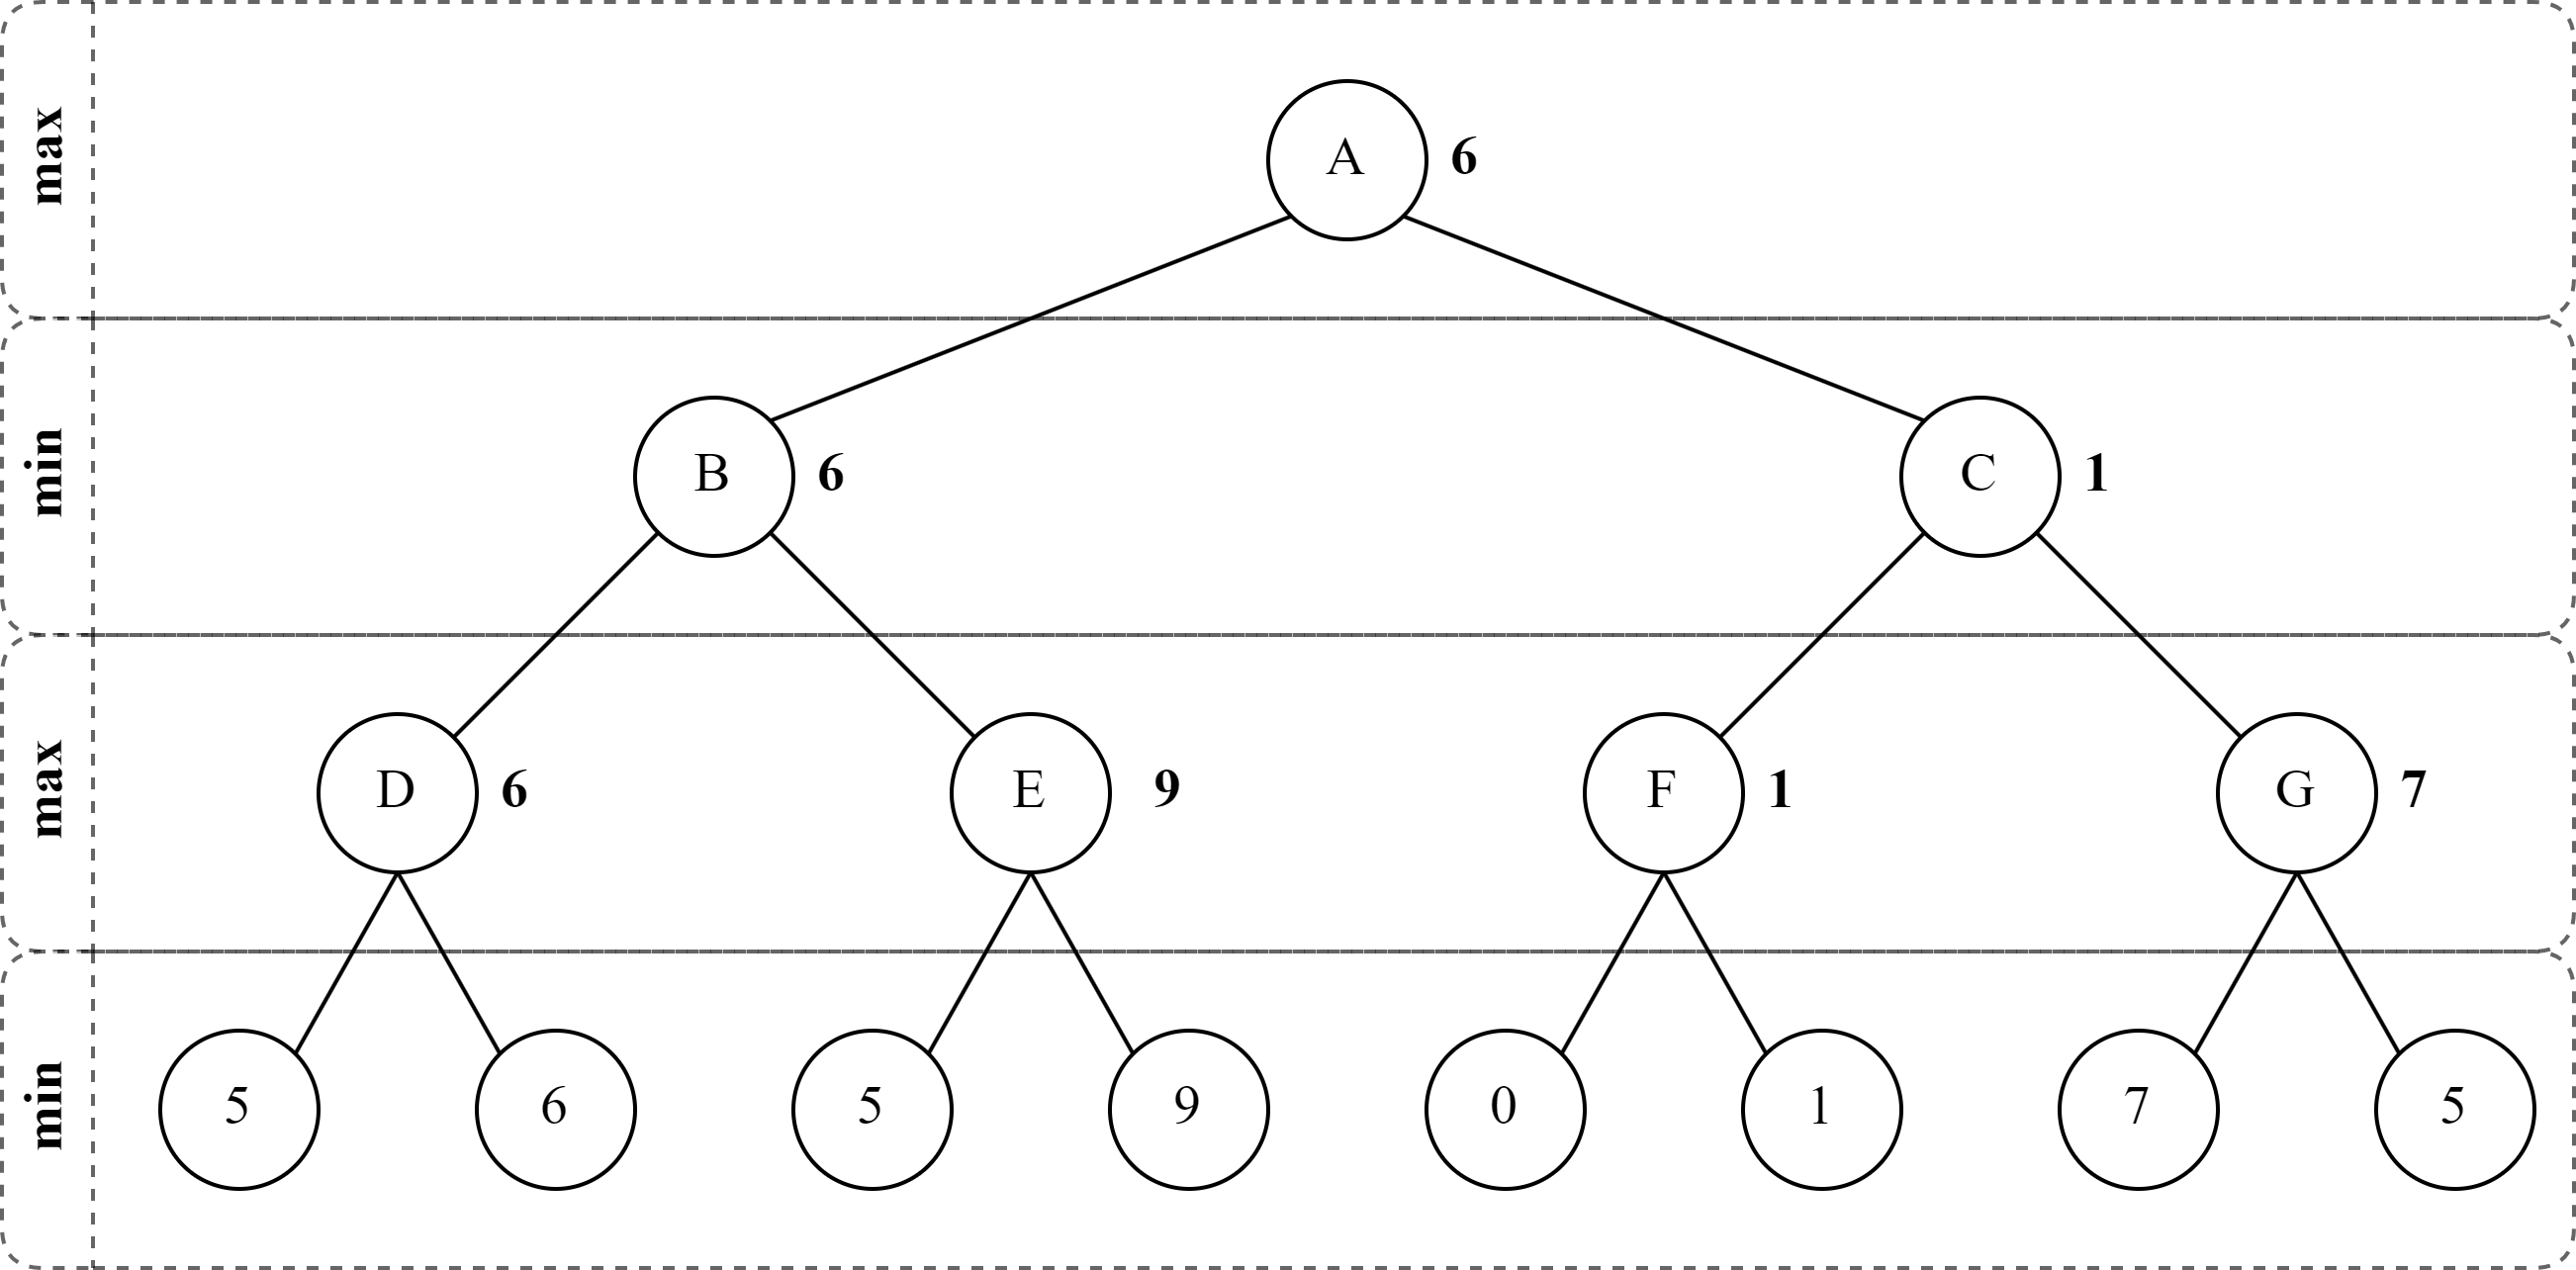

## Minimax-function non incremental no memoization
### MaxValue
This function looks for the maximum value that white can achieve from a position. Meanwhile black tries to minimize the value of the position. Therefore white will take the maximal value of the minimum value of the next move that can happen.

Note: The depth is subtracted/added to give a better/worse rating to evaluate short mating paths as a petter path. (if there is a Mate in 3 (M3) and M1 Path then choose the M1 Path)

The function `maxValue_noIncNoMem` is the **non-incremental** implementation of the maxValue function. 

Arguments:

1. `State::Board` is the current state
1. `depth::Int64` is the maximal plys minimax should calculate 

Returns the maximal score white can achieve with perfect play.

In [ ]:
function maxValue_noIncNoMem(State::Board, depth::Int64)::Int64
    if isterminal(State) || depth == 0
        return evaluate_position(State) - depth
    end
    return maximum([ minValue_noIncNoMem(domove(State, ns), depth-1) for ns in moves(State) ])
end

### MinValue

MinValue does the opposite of the MaxValue function. Therefore it looks for the minimum value that black can achieve from a position. Meanwhile white tries to maximize the value of the position. Therefore black will take the minimal value of the maximum value of the next move that can happen.

The function `minValue_noIncNoMem` is the **non-incremental** implementation of the minValue function. 

Arguments:

1. `State::Board` is the current state
1. `depth::Int64` is the maximal plys minimax should calculate 

Returns the minimal score black can achieve with perfect play.

In [ ]:
function minValue_noIncnoMem(State::Board, depth::Int64)::Int64
    if isterminal(State) || depth == 0
      return evaluate_position(State) + depth
    end
    return minimum([ maxValue_noIncNoMem(domove(State, ns), depth-1) for ns in moves(State) ])
end

## Minimax incremental but no Memoization

The function `maxValue_NoMem` is the **incremental** implementation of the maxValue function. 

Arguments:

1. `State::Board` is the current state
1. `score::Int64` current evaluation of the board
1. `depth::Int64` is the maximal plys minimax should calculate 

Returns the minimal score white can achieve with perfect play.

In [ ]:
function maxValue_noMem(State::Board, score::Int64, depth::Int64)::Int64
    if isterminal(State) 
        return terminal_evaluation(State) - depth
    end
    if depth == 0
        return score
    end
    value = -Inf
    for move in moves(State)
        nextEval = evaluate_move(State, move, score)
        undoinfo = domove!(State, move)
        value = max(minValue_noMem(State, nextEval, depth-1), value)
        undomove!(State, undoinfo)
    end
    return value
end

The function `minValue_NoMem` is the **incremental** implementation of the minValue function. 

Arguments:

1. `State::Board` is the current state
1. `score::Int64` current evaluation of the board
1. `depth::Int64` is the maximal plys minimax should calculate 

Returns the minimal score black can achieve with perfect play.

In [ ]:
function minValue_noMem(State::Board, score::Int64, depth::Int64)::Int64
    if isterminal(State) 
        return terminal_evaluation(State) + depth
    end
    if depth == 0
        return score
    end
    value = Inf
    for move in moves(State)
        nextEval = evaluate_move(State, move, score)
        undoinfo = domove!(State, move)
        value = min(maxValue_noMem(State, nextEval, depth-1), value)
        undomove!(State, undoinfo)
    end
    return value
end

## Minimax incremental and with Memoization

The function `maxValue` is the **incremental** implementation of the maxValue function using a cache. 

Arguments:

1. `State::Board` is the current state
1. `depth::Int64` is the maximal plys minimax should calculate
1. `cache` is the cache that is used to save the entries

Returns the minimal score white can achieve with perfect play.

In [ ]:
function maxValue(aBoard::AdvBoard, depth::Int64, cache)::Int64
    # Memoization
    entry = ("maxValue", aBoard.hash, depth)
    if entry in keys(cache)
        return cache[entry]
    end
    if isterminal(aBoard.state)
        result = terminal_evaluation(aBoard) - depth
    elseif depth == 0
        result = aBoard.score
    else
        result = -200000
        for move in moves(aBoard.state)
            undoinfo = domoveAdv!(aBoard, move)
            result = max(minValue(aBoard, depth-1, cache), result)
            undomoveAdv!(aBoard, undoinfo)
        end
    end
    # Save in Cache
    merge!(cache, Dict(entry => result))
    return result
end

The function `minValue` is the **incremental** implementation of the minValue function that uses a cache. 

Arguments:

1. `State::Board` is the current state
1. `depth::Int64` is the maximal plys minimax should calculate 
1. `cache` is the cache that is used to save the entries

Returns the minimal score black can achieve with perfect play.

In [ ]:
function minValue(aBoard::AdvBoard, depth::Int64, cache)::Int64
    # Memoization
    entry = ("minValue", aBoard.hash, depth)
    if entry in keys(cache)
        return cache[entry]
    end
    if isterminal(aBoard.state)
        result = terminal_evaluation(aBoard) + depth
    elseif depth == 0
        result = aBoard.score
    else
        result = 200000
        for move in moves(aBoard.state)
            undoinfo = domoveAdv!(aBoard, move)
            result = min(maxValue(aBoard, depth-1, cache), result)
            undomoveAdv!(aBoard, undoinfo)
        end
    end
    # Save in Cache
    merge!(cache, Dict(entry => result))
    return result
end

## Minimax-function

### non-incremental implementation 

`minimax` is a function that implements the minimax algorithm to determine the best move for the current player at the current game state. This is the non-incremental implementation and does not have AdvBoard implemented into it. 

Arguments:

1. `State::Board` An advanced chess board in the current state.
1. `score::Int64` current evaluation of the board
1. `depth::Int64:` The maximum depth to search.

Returns a `Tuple{Int64, Move}` containing the best score and the corresponding best move

In [ ]:
function minimax_noMem(State::Board, score::Int64, depth::Int64)::Tuple{Int64, Move}
    next_moves = moves(State)
    if sidetomove(State) == WHITE
        bestVal = maxValue_noMem(State, score, depth)
        BestMoves = [move for move in next_moves 
                     if minValue_noMem(domove(State, move), evaluate_move(State, move, score), depth-1) == bestVal]
    elseif sidetomove(State) == BLACK
        bestVal = minValue_noMem(State, score, depth)
        BestMoves = [move for move in next_moves 
                     if maxValue_noMem(domove(State, move), evaluate_move(State, move, score), depth-1) == bestVal]
    end
    BestMove = rand(BestMoves)
    return bestVal, BestMove
end

### incremental implementation 

`minimax` is a function that implements the minimax algorithm to determine the best move for the current player at the current game state.

Arguments:

1. `aBoard::AdvBoard:` An advanced chess board in the current state.
1. `depth::Int64:` The maximum depth to search.
1. `cache::Dict{}`: a dictionary that stores previously calculated values

Returns a `Tuple{Int64, Move}` containing the best score and the corresponding best move

In [ ]:
function minimax(aBoard::AdvBoard, depth::Int64, cache=Dict())::Tuple{Int64, Move}
    BestMoves = []
    side = sidetomove(aBoard.state)
    bestVal = (side == WHITE) ? -200000 : 200000
    if side == WHITE
        bestVal = maxValue(aBoard, depth, cache)
        for move in moves(aBoard.state)
            undoinfo = domoveAdv!(aBoard, move)
            if minValue(aBoard, depth-1, cache) == bestVal
                append!(BestMoves, [move])
            end
            undomoveAdv!(aBoard, undoinfo)
        end
    elseif side == BLACK
        bestVal = minValue(aBoard, depth, cache)
        for move in moves(aBoard.state)
            undoinfo = domoveAdv!(aBoard, move)
            if maxValue(aBoard, depth-1, cache) == bestVal
                append!(BestMoves, [move])
            end
            undomoveAdv!(aBoard, undoinfo)
        end
    end
    BestMove = rand(BestMoves)
    return bestVal, BestMove
end